<a href="https://colab.research.google.com/github/Luo-Kevin/MAIS202/blob/main/MAIS_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [48]:
! pip install -q transformers
! apt-get install git-lfs
! pip install datasets

Reading package lists... Done
Building dependency tree       
Reading state information... Done
git-lfs is already the newest version (2.9.2-1).
0 upgraded, 0 newly installed, 0 to remove and 23 not upgraded.
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [49]:
from datasets import load_dataset
from transformers import RobertaTokenizer
from transformers import pipeline
import tensorflow as tf
from transformers import TFRobertaModel
import pandas as pd

In [84]:
# Defining some key variables that will be used later on in the training
MAX_LEN = 62
TRAIN_BATCH_SIZE = 32
VALID_BATCH_SIZE = 4
# EPOCHS = 1
LEARNING_RATE = 1e-05

In [51]:
gpus = tf.config.list_physical_devices('GPU')
if gpus:
  try:
    # Currently, memory growth needs to be the same across GPUs
    for gpu in gpus:
      tf.config.experimental.set_memory_growth(gpu, True)
    logical_gpus = tf.config.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    # Memory growth must be set before GPUs have been initialized
    print(e)

1 Physical GPUs, 1 Logical GPUs


In [52]:
#getting the dataset from huggingface
data = load_dataset('SetFit/sst2')

Extracting data files:   0%|          | 0/3 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

Generating test split: 0 examples [00:00, ? examples/s]

Generating validation split: 0 examples [00:00, ? examples/s]

Dataset json downloaded and prepared to /root/.cache/huggingface/datasets/SetFit___json/SetFit--sst2-67a650649f1843ed/0.0.0/0f7e3662623656454fcd2b650f34e886a7db4b9104504885bd462096cc7a9f51. Subsequent calls will reuse this data.


  0%|          | 0/3 [00:00<?, ?it/s]

In [53]:
data_train = data["train"]
data_valid = data['validation']
data_test = data['test']

In [54]:
#to pandas to view
data_train_pd = pd.DataFrame(data_train)
data_valid_pd = pd.DataFrame(data_valid)
data_train_pd.dropna()
data_valid_pd.dropna()

,text,label,label_text
0,one long string of cliches .,0,negative
1,if you 've ever entertained the notion of doin...,0,negative
2,k-19 exploits our substantial collective fear ...,0,negative
3,it 's played in the most straight-faced fashio...,0,negative
4,"there is a fabric of complex ideas here , and ...",1,positive
...,...,...,...
867,something like scrubbing the toilet .,0,negative
868,"smart , provocative and blisteringly funny .",1,positive
869,"this one is definitely one to skip , even for ...",0,negative
870,charles ' entertaining film chronicles seinfel...,1,positive


1    3610
0    3310
Name: label, dtype: int64


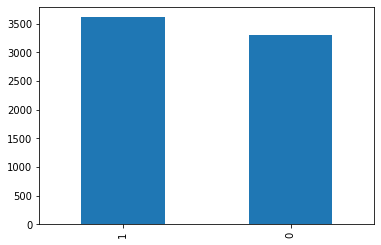

In [55]:
#see label distribution

data_train_pd['label'].value_counts().plot(kind='bar')
print(data_train_pd['label'].value_counts())

In [56]:
y_train = data_train['label']
y_valid = data_valid['label']
y_test = data_test['label']

In [57]:
task='sentiment'
MODEL = f"cardiffnlp/twitter-roberta-base-{task}"
tokenizer = RobertaTokenizer.from_pretrained(MODEL)

In [58]:
#Preprocess function

def preprocess(data):
  return tokenizer(data['text'], truncation=True, padding=True, max_length=MAX_LEN, return_tensors='tf')

In [59]:
preprocess_train = preprocess(data_train)
preprocess_valid = preprocess(data_valid)
preprocess_test = preprocess(data_test)
preprocess_train

{'input_ids': <tf.Tensor: shape=(6920, 62), dtype=int32, numpy=
array([[    0,   102, 21881, ...,     1,     1,     1],
       [    0,  3340, 45314, ...,     1,     1,     1],
       [    0, 10010, 38337, ...,     1,     1,     1],
       ...,
       [    0,   627,  8543, ...,     1,     1,     1],
       [    0,   102,  3640, ...,     1,     1,     1],
       [    0,   102, 24234, ...,     1,     1,     1]], dtype=int32)>, 'attention_mask': <tf.Tensor: shape=(6920, 62), dtype=int32, numpy=
array([[1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       ...,
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0]], dtype=int32)>}

In [60]:
#Reformating input to this structure
def map_features(input_ids, input_mask,label):
    return ({"input_ids":input_ids, 'attention_mask': input_mask}, label) #(input, output) reformat


In [61]:
train_ds =  tf.data.Dataset.from_tensor_slices((preprocess_train['input_ids'], preprocess_train['attention_mask'], y_train)).map(map_features)
valid_ds =  tf.data.Dataset.from_tensor_slices((preprocess_valid['input_ids'], preprocess_valid['attention_mask'], y_valid)).map(map_features)
test_ds =  tf.data.Dataset.from_tensor_slices((preprocess_test['input_ids'], preprocess_test['attention_mask'], y_test)).map(map_features)
train_ds

<MapDataset element_spec=({'input_ids': TensorSpec(shape=(62,), dtype=tf.int32, name=None), 'attention_mask': TensorSpec(shape=(62,), dtype=tf.int32, name=None)}, TensorSpec(shape=(), dtype=tf.int32, name=None))>

In [62]:
#input pipeline
train_ds = train_ds.cache().batch(TRAIN_BATCH_SIZE).prefetch(buffer_size=10)
valid_ds = valid_ds.cache().batch(TRAIN_BATCH_SIZE).prefetch(buffer_size=10)
test_ds = test_ds.cache().batch(TRAIN_BATCH_SIZE).prefetch(buffer_size=10)
train_ds

<PrefetchDataset element_spec=({'input_ids': TensorSpec(shape=(None, 62), dtype=tf.int32, name=None), 'attention_mask': TensorSpec(shape=(None, 62), dtype=tf.int32, name=None)}, TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

# Transfer Learning


In [77]:
base_model = TFRobertaModel.from_pretrained(MODEL) # bringing in pretrained model
base_model.trainable = False # Don't want to change the weights of pre-defined model -> only want to train the new layers

input_ids = tf.keras.layers.Input(shape=(MAX_LEN,), dtype=tf.int32, name='input_ids')
attention_mask = tf.keras.layers.Input(shape=(MAX_LEN,), dtype=tf.int32, name='attention_mask')

# Inference mode: just want the model to output and make predictions, and not train
# Transformer
x = base_model(input_ids, attention_mask=attention_mask, training=False)[1] # Don't want to change the weights of pre-defined model

# Classifier head
x = tf.keras.layers.Dense(128, activation='relu')(x)
x = tf.keras.layers.Dropout(0.5)(x)
y = tf.keras.layers.Dense(1, activation='sigmoid', name='classifier')(x)

model = tf.keras.Model(inputs=[input_ids, attention_mask], outputs=y)
model.summary()

Some layers from the model checkpoint at cardiffnlp/twitter-roberta-base-sentiment were not used when initializing TFRobertaModel: ['classifier']
- This IS expected if you are initializing TFRobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFRobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFRobertaModel were initialized from the model checkpoint at cardiffnlp/twitter-roberta-base-sentiment.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFRobertaModel for predictions without further training.


Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_ids (InputLayer)         [(None, 62)]         0           []                               
                                                                                                  
 attention_mask (InputLayer)    [(None, 62)]         0           []                               
                                                                                                  
 tf_roberta_model_4 (TFRobertaM  TFBaseModelOutputWi  124645632  ['input_ids[0][0]',              
 odel)                          thPoolingAndCrossAt               'attention_mask[0][0]']         
                                tentions(last_hidde                                               
                                n_state=(None, 62,                                          

In [78]:
model.compile(
    optimizer= tf.keras.optimizers.Adam(),
    loss= tf.keras.losses.BinaryCrossentropy(from_logits=True),
    metrics = [tf.keras.metrics.BinaryAccuracy()],
)

epoch = 10
model.fit(train_ds, epochs=epoch, validation_data=valid_ds)

Epoch 1/10


/usr/local/lib/python3.9/dist-packages/keras/backend.py:5676: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Sigmoid activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


217/217 [==============================] - 52s 175ms/step - loss: 0.3270 - binary_accuracy: 0.8584 - val_loss: 0.2875 - val_binary_accuracy: 0.8739
Epoch 2/10
217/217 [==============================] - 35s 161ms/step - loss: 0.2883 - binary_accuracy: 0.8802 - val_loss: 0.2784 - val_binary_accuracy: 0.8773
Epoch 3/10
217/217 [==============================] - 35s 159ms/step - loss: 0.2787 - binary_accuracy: 0.8819 - val_loss: 0.2723 - val_binary_accuracy: 0.8761
Epoch 4/10
217/217 [==============================] - 36s 165ms/step - loss: 0.2718 - binary_accuracy: 0.8831 - val_loss: 0.2638 - val_binary_accuracy: 0.8842
Epoch 5/10
217/217 [==============================] - 34s 158ms/step - loss: 0.2634 - binary_accuracy: 0.8915 - val_loss: 0.2605 - val_binary_accuracy: 0.8865
Epoch 6/10
217/217 [==============================] - 36s 165ms/step - loss: 0.2650 - binary_accuracy: 0.8896 - val_loss: 0.2584 - val_binary_accuracy: 0.8922
Epoch 7/10
217/217 [==============================] - 35s

In [80]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [81]:
model.save_weights('./checkpoints/my_checkpoint')

KeyboardInterrupt: ignored

In [82]:
base_model.trainable = True
model.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_ids (InputLayer)         [(None, 62)]         0           []                               
                                                                                                  
 attention_mask (InputLayer)    [(None, 62)]         0           []                               
                                                                                                  
 tf_roberta_model_4 (TFRobertaM  TFBaseModelOutputWi  124645632  ['input_ids[0][0]',              
 odel)                          thPoolingAndCrossAt               'attention_mask[0][0]']         
                                tentions(last_hidde                                               
                                n_state=(None, 62,                                          

In [85]:
model.compile(
    optimizer= tf.keras.optimizers.Adam(LEARNING_RATE),
    loss= tf.keras.losses.BinaryCrossentropy(from_logits=True),
    metrics = [tf.keras.metrics.BinaryAccuracy()],
)

epoch = 3
model.fit(train_ds, epochs=epoch, validation_data=valid_ds)

Epoch 1/3
217/217 [==============================] - 151s 430ms/step - loss: 0.1643 - binary_accuracy: 0.9370 - val_loss: 0.2160 - val_binary_accuracy: 0.9186
Epoch 2/3
217/217 [==============================] - 88s 405ms/step - loss: 0.0588 - binary_accuracy: 0.9803 - val_loss: 0.3788 - val_binary_accuracy: 0.9197
Epoch 3/3
217/217 [==============================] - 89s 411ms/step - loss: 0.0129 - binary_accuracy: 0.9970 - val_loss: 0.4846 - val_binary_accuracy: 0.9163


In [86]:
model.save_weights('./checkpoints/my_checkpoint2')

In [87]:
predictions = model.predict(test_ds)

57/57 [==============================] - 19s 142ms/step


In [88]:
predictions

array([[6.9388314e-08],
       [9.4010984e-06],
       [2.8810897e-05],
       ...,
       [2.1272582e-04],
       [1.6771078e-04],
       [2.1852018e-06]], dtype=float32)

In [89]:
print(model.evaluate(x=test_ds))

57/57 [==============================] - 9s 151ms/step - loss: 0.3358 - binary_accuracy: 0.9303
[0.33582624793052673, 0.9302580952644348]
